In [1]:
import numpy as np
import time
import torch
import matplotlib.pyplot as plt
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
def solver(
    I: np.ndarray,
    V: np.ndarray,
    f: np.ndarray,
    c,
    L,
    dt,
    C,
    T,
    user_action=None,
    version="vectorized",
):
    """Solve u_tt=c^2*u_xx + f on (0,L)x(0,T]."""
    Nt = int(round(T / dt))
    t = np.linspace(0, Nt * dt, Nt + 1)  # Mesh points in time
    dx = dt * c / float(C)
    Nx = int(round(L / dx))
    x = np.linspace(0, L, Nx + 1)  # Mesh points in space
    C2 = C**2  # Help variable in the scheme
    # if f is None or f == 0:
    #     f = (lambda x, t: 0) if version == "scalar" else lambda x, t: np.zeros(x.shape)
    # if V is None or V == 0:
    #     V = (lambda x: 0) if version == "scalar" else lambda x: np.zeros(x.shape)

    u = np.zeros(Nx + 1)  # Solution array at new time level
    u_1 = np.zeros(Nx + 1)  # Solution at 1 time level back
    u_2 = np.zeros(Nx + 1)  # Solution at 2 time levels back

    t0 = time.perf_counter()  # for measuring CPU time

    # Load initial condition into u_1
    for i in range(0, Nx + 1):
        u_1[i] = I[i]

    if user_action is not None:
        user_action(u_1, x, t, 0)

    # Special formula for first time step
    n = 0
    for i in range(1, Nx):
        u[i] = (
            u_1[i]
            + dt * V[i]
            + 0.5 * C2 * (u_1[i - 1] - 2 * u_1[i] + u_1[i + 1])
            + 0.5 * dt**2 * f[i, n]
        )
    u[0] = 0
    u[Nx] = 0

    if user_action is not None:
        user_action(u, x, t, 1)

    # Switch variables before next step
    u_2[:] = u_1
    u_1[:] = u

    for n in range(1, Nt):
        # Update all inner points at time t[n+1]

        if version == "scalar":
            for i in range(1, Nx):
                u[i] = (
                    -u_2[i]
                    + 2 * u_1[i]
                    + C2 * (u_1[i - 1] - 2 * u_1[i] + u_1[i + 1])
                    + dt**2 * f[i, n]
                )
        elif version == "vectorized":  # (1:-1 slice style)
            f_a = f[:, n]  # Precompute in array
            u[1:-1] = (
                -u_2[1:-1]
                + 2 * u_1[1:-1]
                + C2 * (u_1[0:-2] - 2 * u_1[1:-1] + u_1[2:])
                + dt**2 * f_a[1:-1]
            )
        elif version == "vectorized2":  # (1:Nx slice style)
            f_a = f[:, n]  # Precompute in array
            u[1:Nx] = (
                -u_2[1:Nx]
                + 2 * u_1[1:Nx]
                + C2 * (u_1[0 : Nx - 1] - 2 * u_1[1:Nx] + u_1[2 : Nx + 1])
                + dt**2 * f_a[1:Nx]
            )

        # Insert boundary conditions
        u[0] = 0
        u[Nx] = 0
        if user_action is not None:
            if user_action(u, x, t, n + 1):
                break

        # Switch variables before next step
        u_2[:] = u_1
        u_1[:] = u

    cpu_time = t0 - time.perf_counter()
    return u, x, t, cpu_time

In [3]:
def test_quadratic():
    """
    Check the scalar and vectorized versions work for
    a quadratic u(x,t)=x(L-x)(1+t/2) that is exactly reproduced.
    """
    L = 1.0
    c = 1.0
    C = 1.0
    Nx = 100  # Very coarse mesh for this exact test
    dt = C * (L / Nx) / c
    T = 1.0

    Nt = int(round(T / dt))
    t = np.linspace(0, Nt * dt, Nt + 1)  # Mesh points in time
    dx = dt * c / float(C)
    Nx = int(round(L / dx))
    x = np.linspace(0, L, Nx + 1).reshape(-1, 1)  # Mesh points in space

    # The following function must work for x as array or scalar
    u_exact = x * (L - x) * (1 + 0.5 * t)
    # f is a scalar (zeros_like(x) works for scalar x too)
    ut = torch.gradient(torch.tensor(u_exact), spacing=dt, dim=1, edge_order=2)[0]
    ux = torch.gradient(torch.tensor(u_exact), spacing=dx, dim=0, edge_order=2)[0]
    utt = torch.gradient(ut, spacing=dt, dim=1,edge_order=2)[0].numpy()
    uxx = torch.gradient(ux, spacing=dx, dim=0, edge_order=2)[0].numpy()
    I = u_exact[:, 0]
    V1 = 0.5 * u_exact[:, 0]
    V = ut[:, 0].numpy()
    V_diff = V1.__sub__(V)
    display(V_diff.max())
    display(V_diff.min())
    display(np.median(V_diff))
    display(V_diff.mean())
    f1 = np.zeros_like(x) + 2 * c**2 * (1 + 0.5 * t)
    f = utt - c**2 * uxx
    diff:np.ndarray = f1.__sub__(f)

    display(diff.max())
    display(diff.min())
    display(np.median(diff))
    display(diff.mean())

    def assert_no_error(u, x, t, n):
        u_e = u_exact[:, n]
        tol = 1e-13
        diff = np.abs(u - u_e).max()
        assert diff < tol
    plt.figure(constrained_layout=True, figsize=(16, 6))
    plt.subplot(131)
    plt.imshow(f1)
    plt.title("exact")
    plt.xlabel("t")
    plt.ylabel("x")
    plt.colorbar()
    plt.subplot(132)
    plt.imshow(f)
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title("torch gradient")
    plt.colorbar()
    plt.subplot(133)
    plt.imshow(diff)
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title("diff")
    plt.colorbar()
    plt.show()

    solver(I, V, f, c, L, dt, C, T, user_action=assert_no_error, version="scalar")
    solver(I, V, f, c, L, dt, C, T, user_action=assert_no_error, version="vectorized")

1.0047518372857667e-14

0.0

3.0808688933348094e-15

3.4173794844543698e-15

2.41229258790554e-12

-1.7226220450083929e-12

-6.217248937900877e-15

-2.0100685267916887e-15

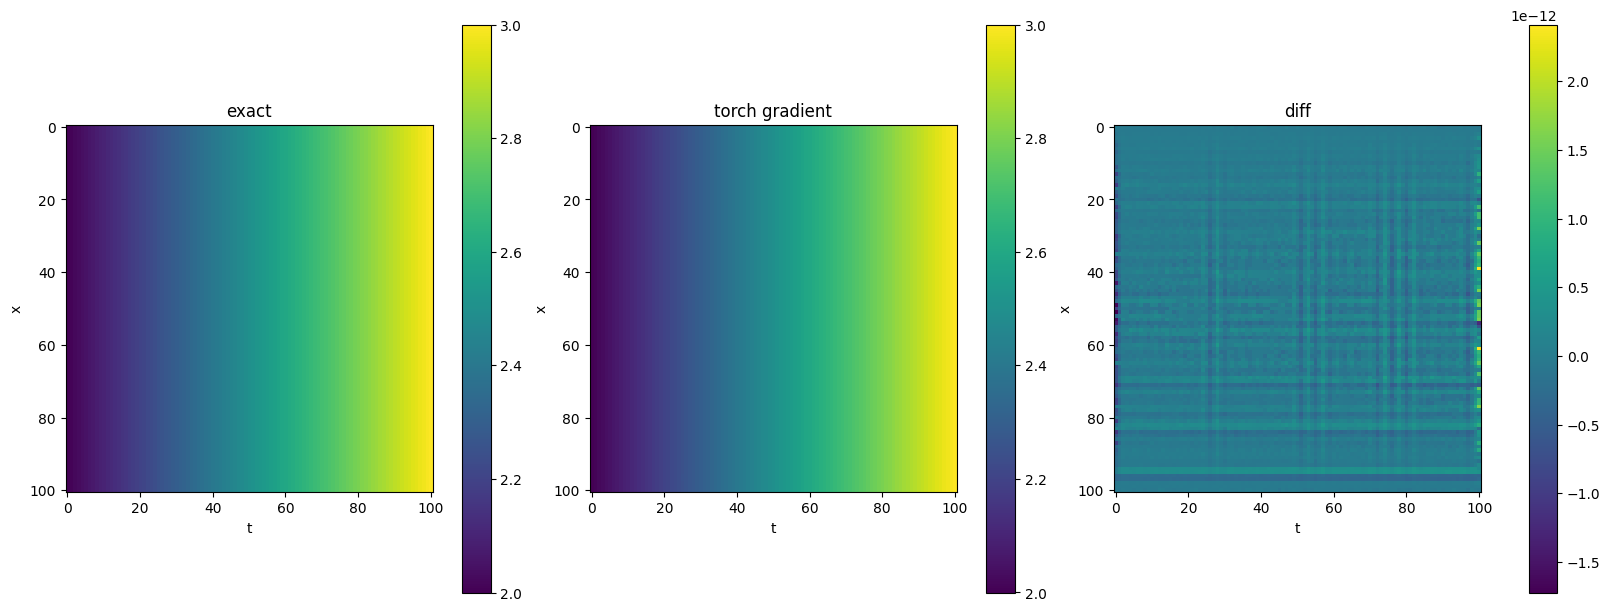

In [4]:
test_quadratic()